In [1]:
import os, sys
import numpy as np
import h5netcdf

import xarray as xr
import xarray.ufuncs as xu
import pandas as pd

from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy

plt.rc("figure", figsize=(16,4))
plt.rc("font", size=14)
ccrs.PlateCarree()

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4)
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46477 instead
  warnings.warn(


<Client: 'inproc://137.129.155.67/33723/1' processes=1 threads=4, memory=78.61 GiB>

In [2]:
def isLeapYear (yearN):
    if ((yearN % 4 == 0) and (yearN % 100 != 0)) or (yearN % 400 == 0):
        reponse = True
    else:
        reponse = False
    print(reponse, '\n')
    return reponse

def hour_mean(x):
     return x.groupby('time.hour').mean('time')
    
def hour_sum(x):
     return x.groupby('time.hour').sum('time')
    
def hour_std(x):
     return x.groupby('time.hour').std('time')

In [3]:
indir_smot = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/SMOTHED_CLIM/'
indir_brut = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_CLIM/'
indir_anom = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/OLR/'

output_fig = '/cnrm/tropics/commun/DATACOMMUN/WAVE/RAPPORT/FIGURES/ANOMALY/OLR/'

var = 'toa_lw_all_1h'

ds_smot = xr.open_mfdataset(indir_smot+'clim_OLR_smooth_ERA5_2000_2020.nc', chunks = {'time' : 1}, parallel=True)
# ds_smot_T = xr.open_mfdataset(indir_smot+'clim_OLR_smooth_ERA5_2012_2016.nc', chunks = {'time' : 1}, parallel=True)

ds_brut = xr.open_mfdataset(indir_brut+'clim_toa_lw_all_1h_brut_ERA5_3H_2000_2020.nc', chunks = {'time' : 1}, parallel=True)
mask = ds_smot.mean('time')
mask

<xarray.Dataset>
Dimensions:        (lat: 60, lon: 360)
Coordinates:
  * lat            (lat) float32 -29.5 -28.5 -27.5 -26.5 ... 26.5 27.5 28.5 29.5
  * lon            (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    toa_lw_all_1h  (lat, lon) float64 dask.array<chunksize=(60, 360), meta=np.ndarray>

In [4]:
# ds_anom = xr.open_mfdataset(indir_anom+'*.nc', engine='h5netcdf', chunks = {'time' : 1}, parallel=True)
filenames = np.arange(2001,2020)
datasets = []
for f in filenames:
    ds = xr.open_mfdataset(indir_anom + 'anom_OLR_brut_ERA5_3H_'+str(f)+'.nc', chunks={'time': 150})
    datasets.append(ds)
ds_anom = xr.concat(datasets, dim='time', coords='minimal', compat='override')
ds_anom

# filenames = np.arange(2012,2017)
# datasets = []
# for f in filenames:
#     ds = xr.open_mfdataset(indir_anom + 'anom_OLR_brut_ERA5_3H_'+str(f)+'_TOUCAN.nc', chunks={'time': 150})
#     datasets.append(ds)
# ds_anom_T = xr.concat(datasets, dim='time', coords='minimal', compat='override')
# ds_anom_T

<xarray.Dataset>
Dimensions:  (time: 55512, lon: 360, lat: 60)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 ... 2019-12-31T21:00:00
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
Data variables:
    OLR_ano  (time, lat, lon) float64 dask.array<chunksize=(150, 60, 360), meta=np.ndarray>

# Verification de la climatologie en 1D
## Moyenne des anomalies + climatologie
\begin{equation}
X= \overline{x^{*}} + \overline{x}
\end{equation}

avec $\overline{x}\rightarrow$ ds_smot \\\
et $\overline{x^{*}}\rightarrow$ ds_mean_anom \\\
$X\rightarrow$ ds_tot

In [5]:
ds_mean_anom = ds_anom.mean('time')

da_tot = ds_mean_anom['OLR_ano'] + ds_smot['toa_lw_all_1h']
# da_tot_T = ds_mean_anom_T['tcwv_ano'] + ds_smot['tcwv_smooth']

##### Sur la période 1990-2020

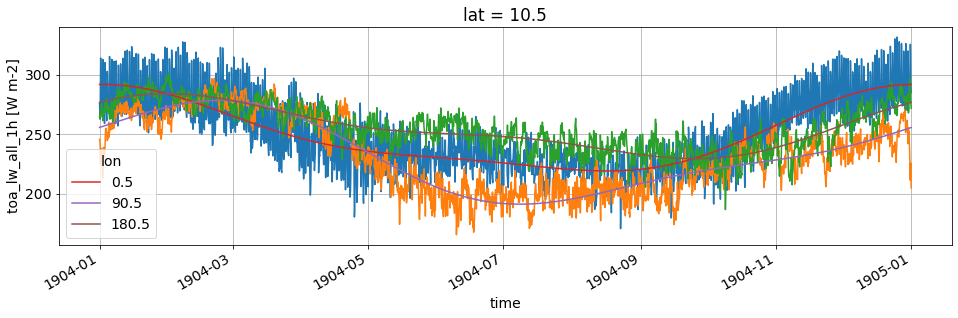

In [6]:
latitude = 10
longitude = [0, 90, 180]

plt.figure()
ds_brut['toa_lw_all_1h'].sel(lat = latitude, lon = longitude, method = 'nearest').plot(hue='lon')
ds_smot['toa_lw_all_1h'].sel(lat = latitude, lon = longitude, method = 'nearest').plot(hue='lon')
# da_tot.sel(lat = latitude, lon = longitude, method = 'nearest').plot(hue='lon')
# da_tot_T.sel(latitude = latitude, longitude = longitude).plot(hue='longitude')
plt.grid()
# plt.legend()
plt.show()

 ##### Sur la période 2012-2016

## Comparaison entre deux années ou période

# Verification pour l'anomalie en 2D pour 1990-2010
## Moyennes mensuelle et saisonnière
\begin{equation}
\overline{tcwv}_j = \frac{\displaystyle\sum_{i=1}^{n_j}x_i} {n_j} = \mu_j\\
\text{$j$ de 1 à 12 ou de 1 à 4, $\mu$ la moyenne mensuelle ou saisonière, n le nombre de pas de temps $n_j = nbAnnee * nbJour_j * \frac{24}{3}$} \\[30pt]
\end{equation}

#### Carte global de l'anomalie de PW en moyenne mensuelle

In [7]:
ds_MMS = ds_anom.groupby("time.month").mean('time').load()
ds_MSS = ds_anom.groupby('time.season').mean('time').load()
ds_MMS

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 60, month: 12)
Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    OLR_ano  (month, lat, lon) float64 -0.00317 0.01205 ... -0.8234 -0.5647

In [8]:
#### Parameter for plotting
vmax = 15
vmin = -vmax
cmap ='RdBu_r'
size = 5
aspect = 3.5
levels = 100

colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 'ticks': np.arange(vmin,vmax+.1,2),
            'extend' : 'both'}


map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.1, 
                         max_latitude=30.1, 
                         globe=None)

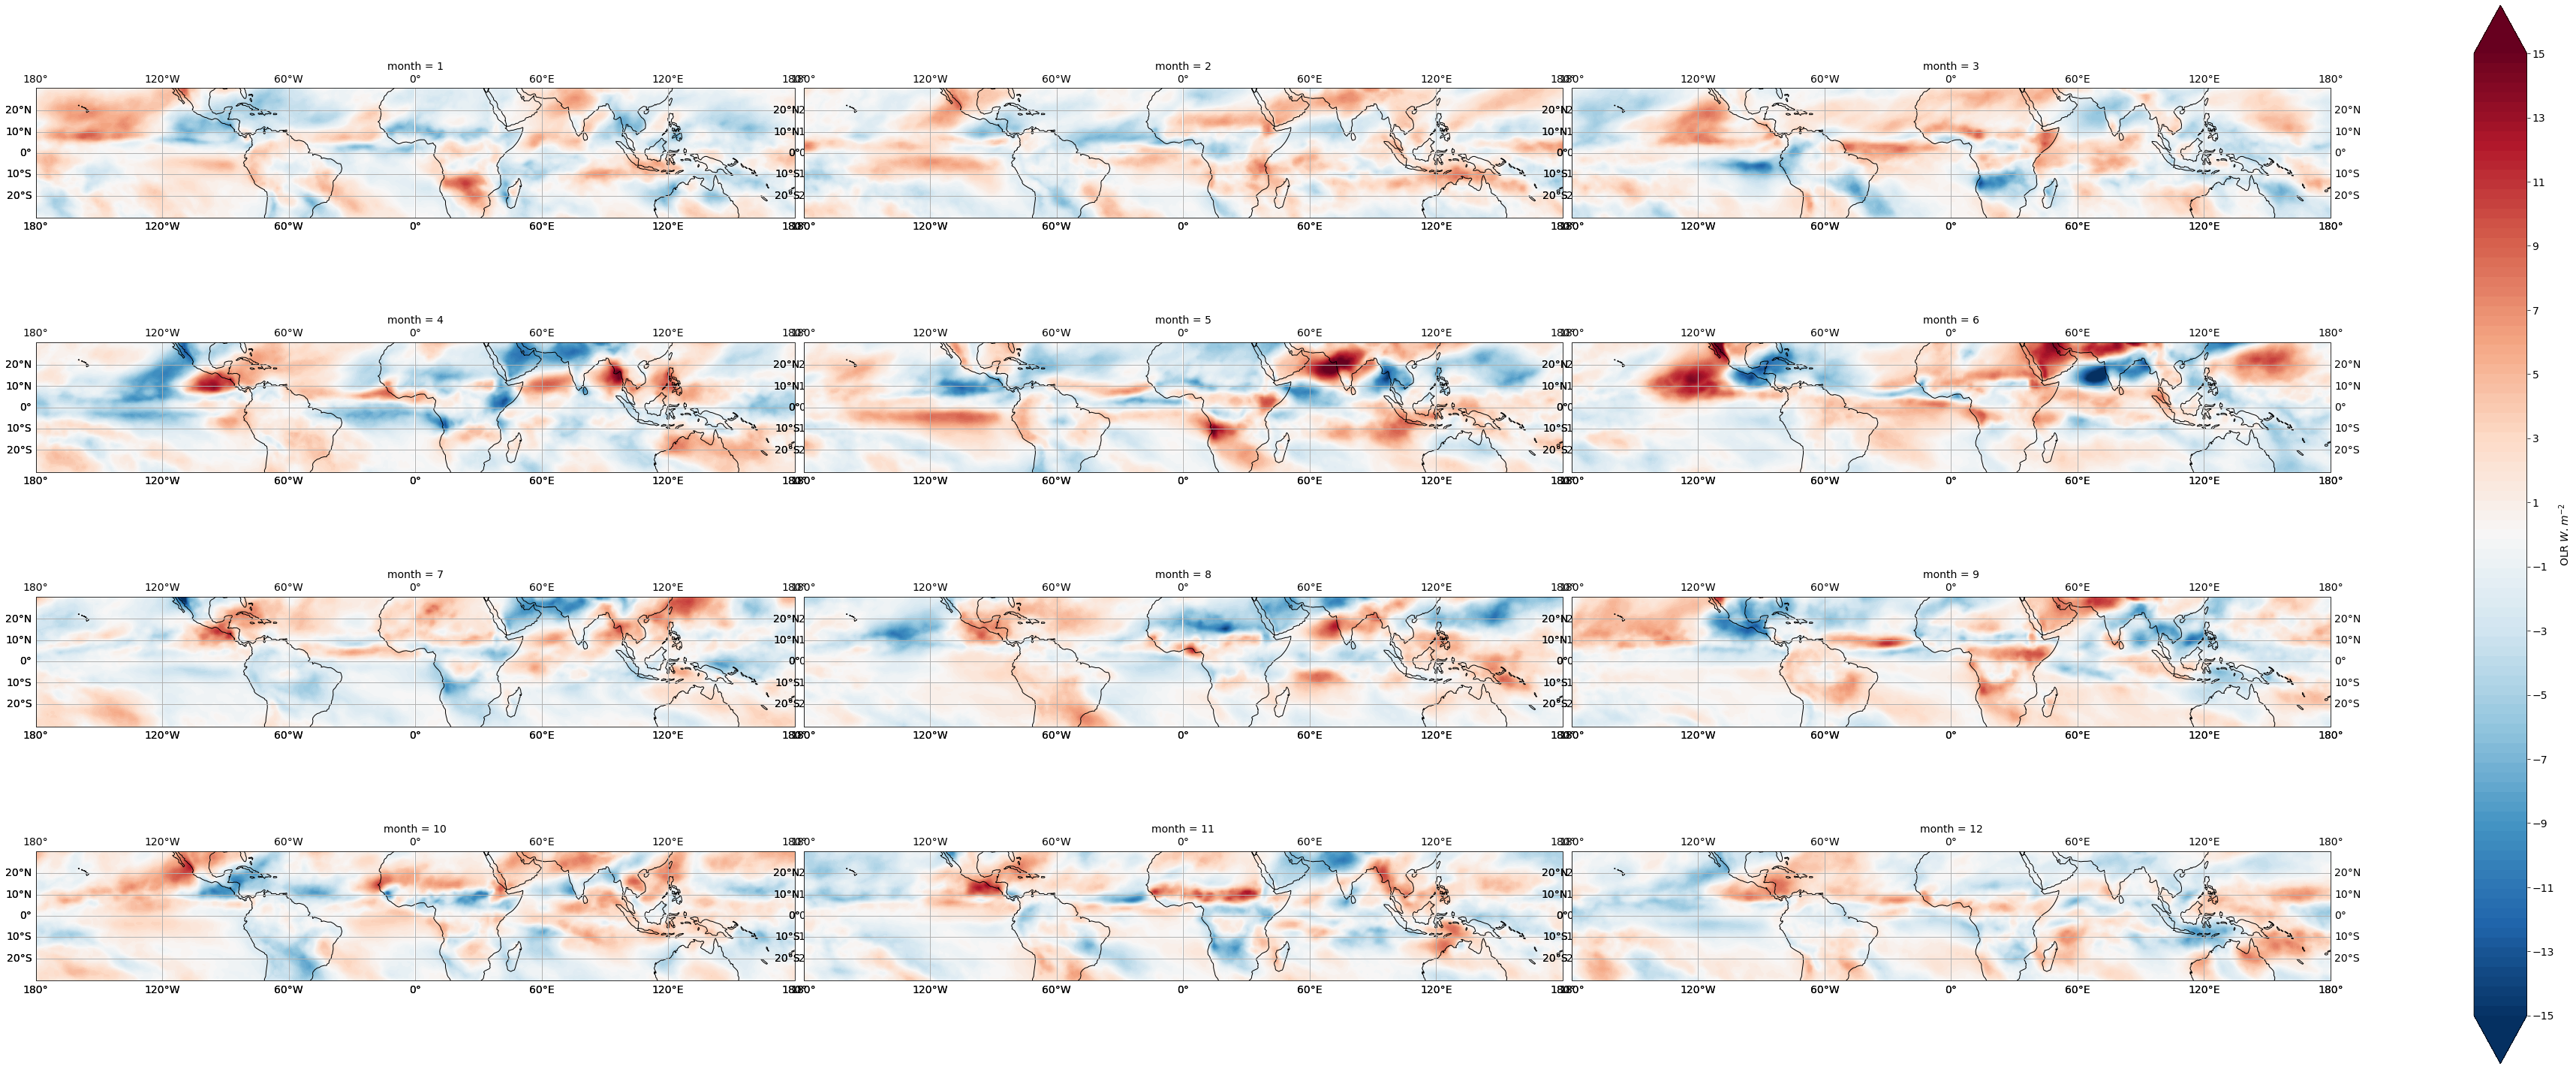

<Figure size 1152x288 with 0 Axes>

In [9]:
p = ds_MMS['OLR_ano'].plot.contourf(transform=ccrs.PlateCarree(),  # the data's projection
                               col = 'month', col_wrap =3, levels = levels,
                               aspect = aspect, size = size,
                               vmin = vmin, vmax = vmax, cmap=cmap,# multiplot settings
                               subplot_kws={'projection': map_proj},
                               cbar_kwargs=colorbar)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
# plt.title("Ecart-type mensuel")
plt.show()
plt.savefig(output_fig+'atlas_meanMonth_anomaly.png')  

#### Carte global de l'anomalie de PW en moyenne saisonnière

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/plot/facetgrid.py:392: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


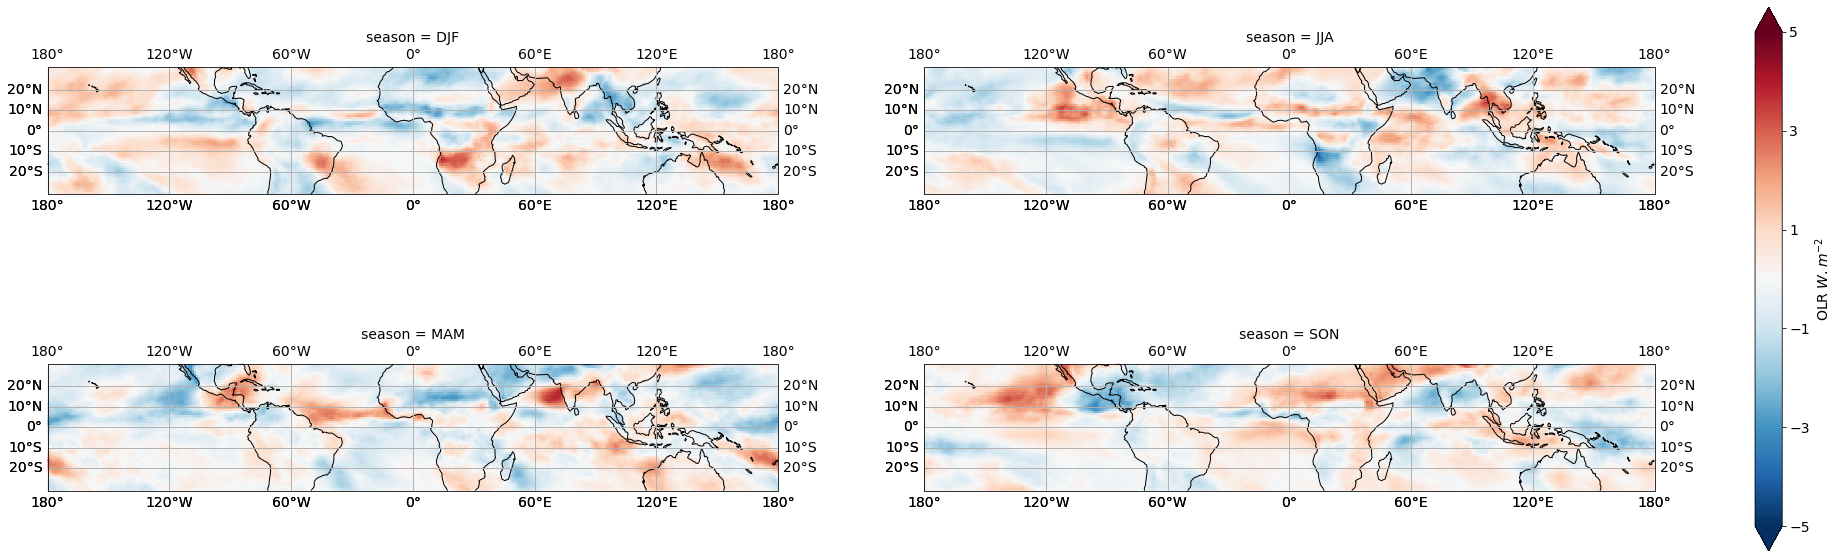

In [10]:
p = ds_MSS['OLR_ano'].plot(transform=ccrs.PlateCarree(),  # the data's projection
                               col = 'season', col_wrap =2,
                               aspect = aspect, size = size,
                               vmin = int(vmin/3), vmax = int(vmax/3), cmap=cmap,# multiplot settings
                               subplot_kws={'projection': map_proj},
                               cbar_kwargs=colorbar)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
plt.savefig(output_fig+'atlas_meanSeason_anomaly.png')



## Calcul de l'écart-type pour l'anomalie
\begin{equation}
\sigma = \sqrt{\frac{\displaystyle\sum_{i=1}^{n}(x_i - \mu_i)^2} {n}} \\
\text{avec n le nombre de pas de temps total,  $\mu$ la moyenne climatologique au pas de temps} \\[30pt]
\sigma_j = \sqrt{\frac{\displaystyle\sum_{i=1}^{n_j}(x_i - \mu_i)^2} {n_j}} \\
\text{$j$ de 1 à 12 ou de 1 à 4, $\mu_i$ la moyenne climatologique au pas de temps, n le nombre de pas de temps $n_j = nbAnnee * nbJour_j * \frac{24}{3}$}
\end{equation}



In [5]:
ds_std_anom  = ds_anom.var('time').load()
ds_std_anom_M = ds_anom.groupby("time.month").var('time').load()
ds_std_anom_S = ds_anom.groupby("time.season").var('time').load()

In [12]:
vmax = 60**2
vmin = 0.
cmap ='viridis'
size = 5
aspect = 4
levelsT = np.linspace(0,vmax,7)

#### Parameter for plotting
colorbar = {'label': 'OLR $W^{2}.m^{-4}$',
            'orientation': 'vertical' ,
            'extend' : 'max',
           'ticks': levelsT}

map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

#### Atlas de la variance sur les douze mois 

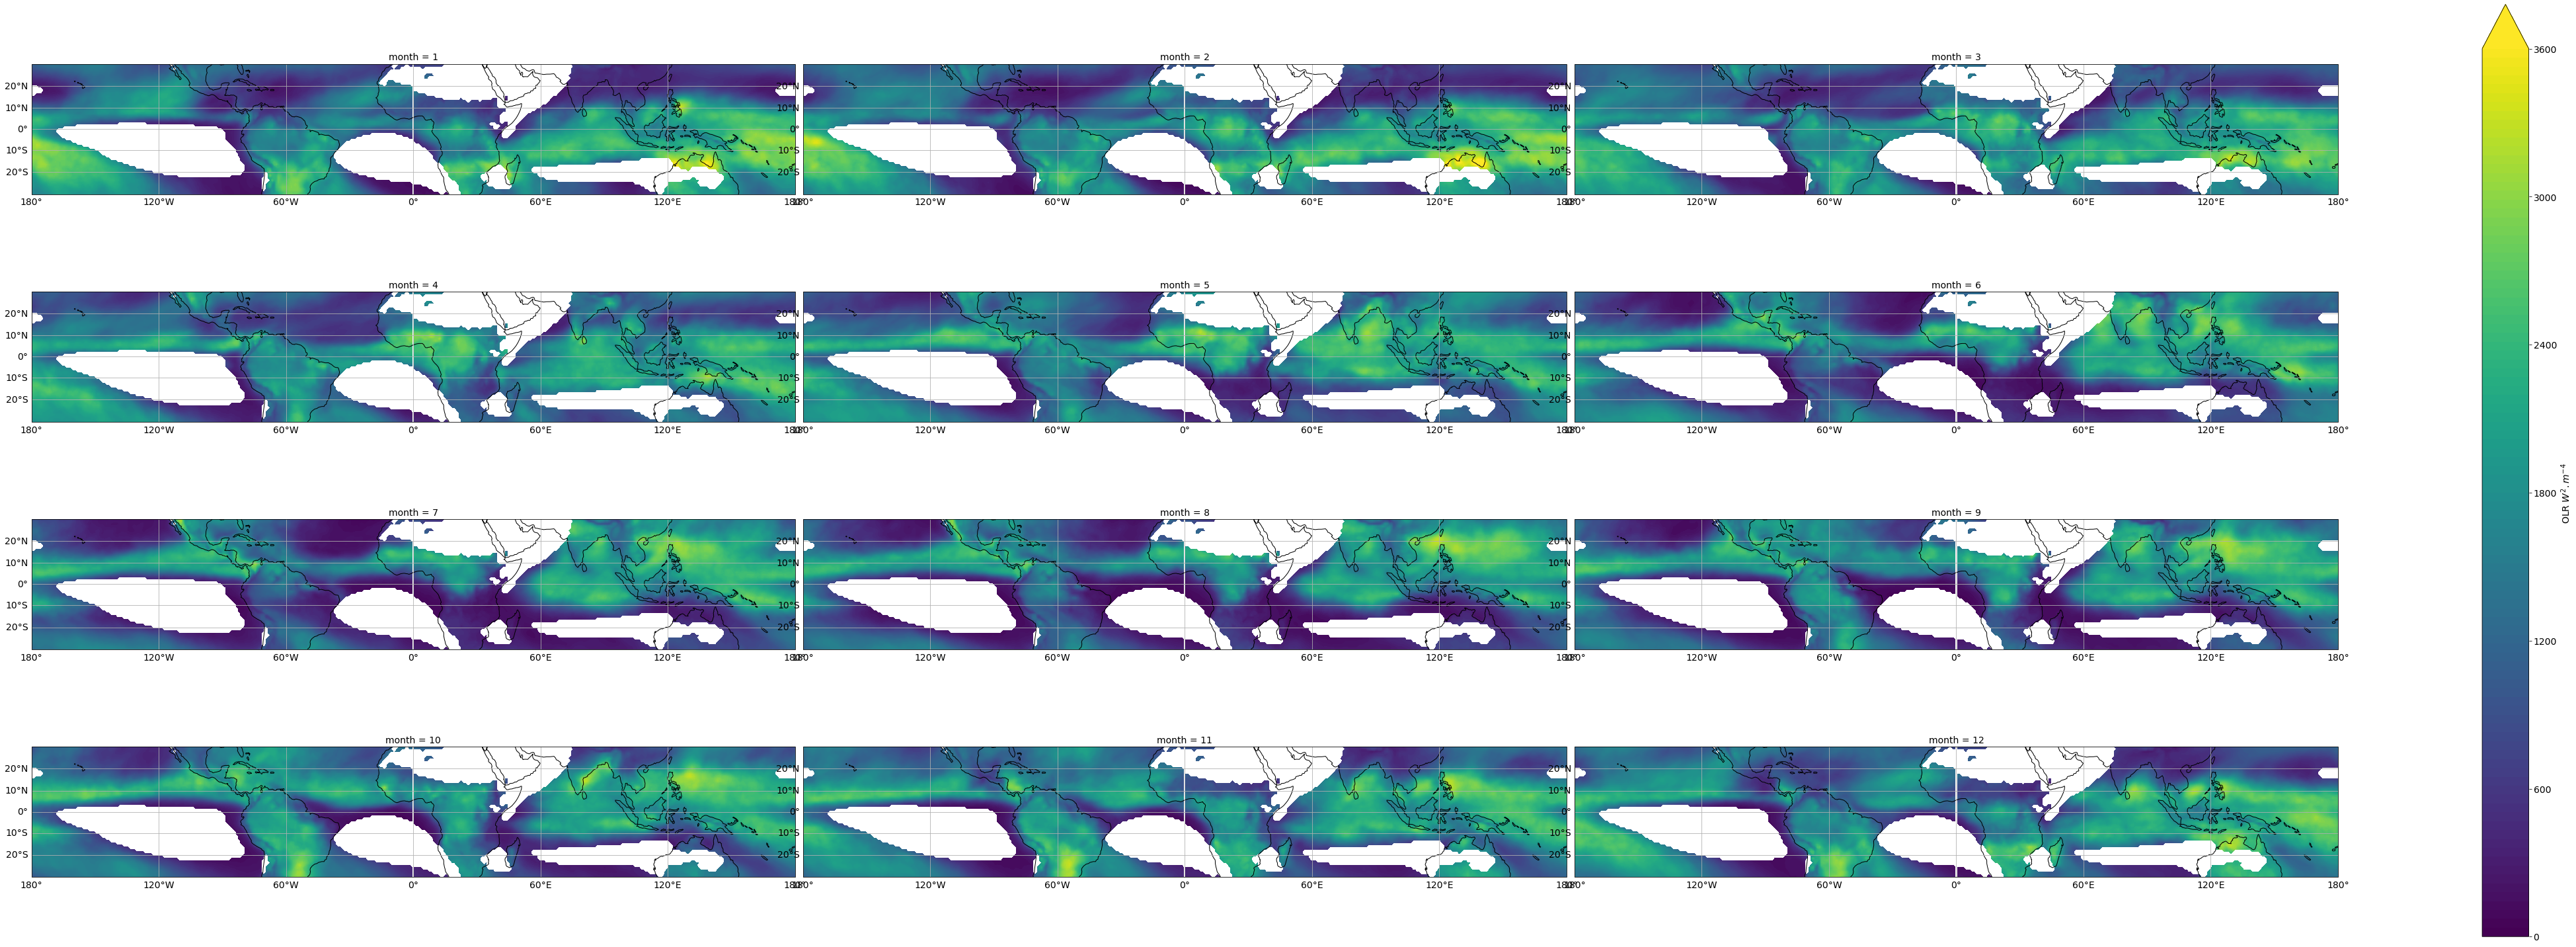

In [13]:
p = ds_std_anom_M['OLR_ano'].where(mask.toa_lw_all_1h < 275).plot.contourf(
                               transform=ccrs.PlateCarree(),  # the data's projection
                               col = 'month', col_wrap =3, levels = 101,
                               aspect = aspect, size = size,
                               vmin = 0., vmax = vmax, cmap=cmap,# multiplot settings
                               subplot_kws={'projection': map_proj},
                               cbar_kwargs=colorbar)

for i in range(12):
    p.axes.flat[i].coastlines()
#     p.axes.flat[i].gridlines(draw_labels=True)
    gl = p.axes.flat[i].gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
plt.savefig(output_fig+'atlas_varMonth_anomaly.png')
# plt.title("Variance de l'OLR pour l\'anomalie")
plt.show()


#### Atlas de la variance saisonière

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/plot/facetgrid.py:392: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


<Figure size 2304x288 with 0 Axes>

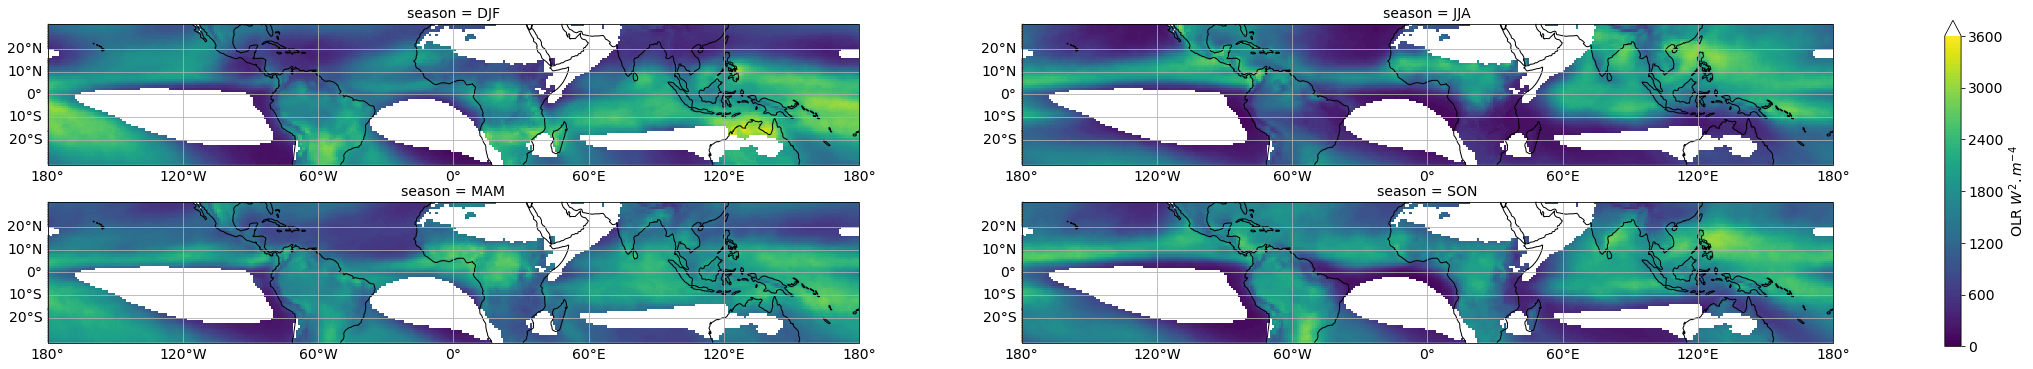

In [14]:
plt.rc("figure", figsize=(32,4))
plt.figure()
p = ds_std_anom_S['OLR_ano'].where(mask.toa_lw_all_1h < 275).plot(
                                transform=ccrs.PlateCarree(),  # the data's projection
                               col = 'season', col_wrap =2, levels = 101,
                              figsize = (40,6),
                               vmin = vmin, vmax = vmax, cmap=cmap,# multiplot settings
                               subplot_kws={'projection': map_proj},
                              cbar_kwargs=colorbar,
                                   robust=True
                                 )


# for ax in p.axes.flat:
for i in range(4):
    p.axes.flat[i].coastlines()
#     p.axes.flat[i].gridlines(draw_labels=True)
    gl = p.axes.flat[i].gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
# plt.tight_layout()
# plt.suptitle("Variance de l'OLR saisonnière pour l\'anomalie")
plt.savefig(output_fig+'atlas_OLR_varSeason_anomaly.png')
plt.show()


#### Atlas de la variance annuelle

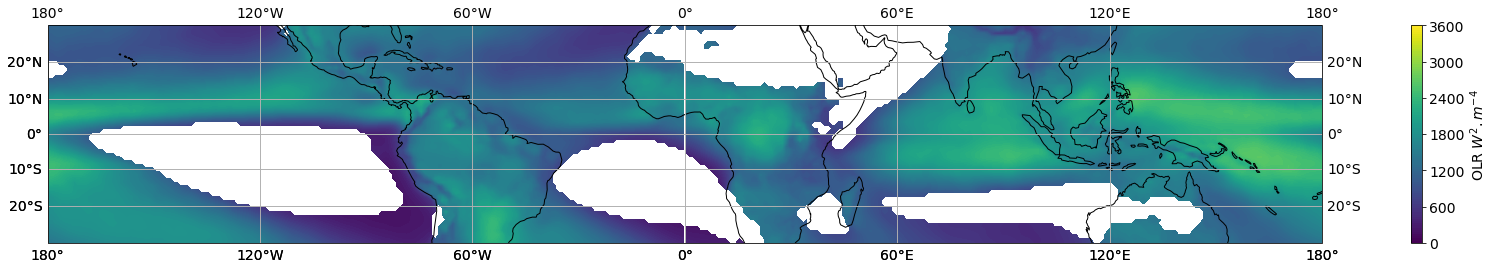

In [15]:
fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_std_anom['OLR_ano'].where(mask.toa_lw_all_1h < 275).plot.contourf(ax=axis, levels = 101,
                    transform=ccrs.PlateCarree(),
                    vmin = vmin, vmax = vmax, cmap=cmap,# multiplot settings
                    cbar_kwargs=colorbar)

axis.coastlines()
axis.gridlines(draw_labels=True)
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.savefig(output_fig+'atlas_varYear_anomaly.png')

# Verification de l'anomalie en 2D pour TOUCAN
## Moyennes mensuelle et saisonnière
\begin{equation}
\overline{OLR}_j = \frac{\displaystyle\sum_{i=1}^{n_j}x_i} {n_j} = \mu_j\\
\text{$j$ de 1 à 12 ou de 1 à 4, $\mu$ la moyenne mensuelle ou saisonière, n le nombre de pas de temps $n_j = nbAnnee * nbJour_j * \frac{24}{3}$} \\[30pt]
\end{equation}


#### Carte global de l'anomalie de PW en moyenne mensuelle



## Calcul de la variance pour l'anomalie
\begin{equation}
\sigma^2 = \frac{\displaystyle\sum_{i=1}^{n}(x_i - \mu)^2} {n} \\
\text{avec n le nombre de pas de temps total,  $\mu$ la moyenne sur l'année} \\[30pt]
\sigma^2_j = \frac{\displaystyle\sum_{i=1}^{n_j}(x_i - \mu_j)^2} {n_j} \\
\text{$j$ de 1 à 12 ou de 1 à 4, $\mu_j$ la moyenne mensuelle ou saisonière, n le nombre de pas de temps $n_j = nbAnnee * nbJour_j * \frac{24}{3}$}
\end{equation}



In [ ]:
ds_std_anom_T  = ds_anom_T.std('time')
ds_std_anom_M_T = ds_anom_T.groupby("time.month").std('time').load()
ds_std_anom_S_T = ds_anom_T.groupby("time.season").std('time').load()

#### Atlas de la variance sur les douze mois 

In [ ]:
p = ds_std_anom_M['OLR_ano'].plot(transform=ccrs.PlateCarree(),  # the data's projection
                               col = 'month', col_wrap =3,
                               aspect = 3, size = size,
                               vmin = 0., vmax = vmax, cmap=cmap,# multiplot settings
                               subplot_kws={'projection': map_proj},
                               cbar_kwargs=colorbar)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

    
# plt.show()
plt.savefig(output_fig+'atlas_varMonth_anomaly_TOUCAN.png')

#### Atlas de la variance saisonière

# Quantile de l'anomalie avec la climatalogie de 20 ans pour la période 2012-2016

In [ ]:
cmap ='viridis'

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

mask['toa_lw_all_1h'].plot.contourf(ax=axis, levels = 101, 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap,
                    )

axis.coastlines()
axis.gridlines(draw_labels=True)
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

In [ ]:
# ds_anom_T = ds_anom_T.chunk(dict(time=-1, longitude=8))
_ds_anom = ds_anom.astype('float16')

# _ds_anom_p = ds_anom_p.isel(time = slice(0,None,8))

ds_quan = _ds_anom.chunk(dict(time=-1, lat = 1)).quantile([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99], dim = 'time')
ds_quan = ds_quan.load()

In [ ]:
map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-40.0, 
                         max_latitude=40.0, 
                         globe=None)


In [ ]:
plt.rc("figure", figsize=(16,4))
cmap ='BrBG'
vmin , vmax = -150, 150
#####################################################################################
colorbar = {'label': 'tcwv $kg.m^{-2}$',
            'orientation': 'vertical' , 
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan['OLR_ano'].sel(quantile = 0.01).plot.contourf(ax=axis, levels = 101, 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap , vmin = vmin, vmax = vmax
                    )

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

#####################################################################################
colorbar = {'label': 'tcwv $kg.m^{-2}$',
            'orientation': 'vertical' , 
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan['OLR_ano'].where(mask.toa_lw_all_1h < 275).sel(quantile = 0.01).plot.contourf(ax=axis, levels = 101, 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap , vmin = vmin, vmax = vmax
                    )

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

#####################################################################################
colorbar = {'label': 'tcwv $kg.m^{-2}$',
            'orientation': 'vertical' , 'ticks': np.arange(-16,0+0.1,1),
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan['OLR_ano'].where(mask.toa_lw_all_1h < 275).sel(quantile = 0.1).plot.contourf(ax=axis, levels = 101, 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap , vmin = vmin, vmax = vmax
                    )

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()
#####################################################################################
colorbar = {'label': 'tcwv $kg.m^{-2}$',
            'orientation': 'vertical' , 'ticks': np.arange(-10,0+0.1,1),
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan['OLR_ano'].where(mask.toa_lw_all_1h < 275).sel(quantile = 0.25).plot.contourf(ax=axis, levels = 101, 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap, vmin = vmin, vmax = vmax
                    )

axis.coastlines()
axis.gridlines(draw_labels=True)
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()
#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan['OLR_ano'].where(mask.toa_lw_all_1h < 275).sel(quantile = 0.5).plot.contourf(ax=axis, levels = 101,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap, vmin = vmin, vmax = vmax
                    )

axis.coastlines()
axis.gridlines(draw_labels=True)
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()
#######################################################################################
# cmap ='RdBu_r'
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 'ticks': np.arange(0,10+0.1,1),
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan['OLR_ano'].where(mask.toa_lw_all_1h < 275).sel(quantile = 0.75).plot.contourf(ax=axis, levels = 101, 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap, vmin = vmin, vmax = vmax
                    )

axis.coastlines()
axis.gridlines(draw_labels=True)
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()
##########################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 'ticks': np.arange(0,16+0.1,1),
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan['OLR_ano'].where(mask.toa_lw_all_1h < 275).sel(quantile = 0.9).plot.contourf(ax=axis, levels = 101, 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap, vmin = vmin, vmax = vmax
                    )

axis.coastlines()
axis.gridlines(draw_labels=True)
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()
##########################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan['OLR_ano'].where(mask.toa_lw_all_1h < 275).sel(quantile = 0.99).plot.contourf(ax=axis, levels = 101, 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap, vmin = vmin, vmax = vmax
                    )

axis.coastlines()
axis.gridlines(draw_labels=True)
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()
# plt.savefig(output_fig+'atlas_varYear_anomaly_TOUCAN.png')

# Ecart Inter-quantile
## Pour la climatologie sur 20 ans

In [ ]:
np.cos(1)

In [ ]:
ds_quan_diff_9_1 = ds_quan.sel(quantile = 0.9) - ds_quan.sel(quantile = 0.1)
ds_quan_diff_99_11 = ds_quan.sel(quantile = 0.99) - ds_quan.sel(quantile = 0.01)
ds_quan_diff_9_5 = ds_quan.sel(quantile = 0.9) - ds_quan.sel(quantile = 0.5)
ds_quan_diff_5_1 = ds_quan.sel(quantile = 0.5) - ds_quan.sel(quantile = 0.1)
ds_quan_diff_75_25 = ds_quan.sel(quantile = 0.75) - ds_quan.sel(quantile = 0.25)

In [ ]:
plt.rc("figure", figsize=(16,4))
cmap ='viridis'

vmin, vmax = 130, 100

#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan_diff_9_1['OLR_ano'].where(mask.toa_lw_all_1h < 275).plot.contourf(ax=axis, levels = 101, 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title("difference inter-quantile 0.90 - 0.10")
plt.show()
#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan_diff_99_11['OLR_ano'].where(mask.toa_lw_all_1h < 275).plot.contourf(ax=axis, levels = 101, 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title("difference inter-quantile 0.99 - 0.01")
plt.show()
#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan_diff_9_5['OLR_ano'].where(mask.toa_lw_all_1h < 275).plot.contourf(ax=axis, levels = 101, 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap,
                    cbar_kwargs=colorbar)

axis.coastlines()
axis.gridlines(draw_labels=True)
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title("difference inter-quantile 0.90 - 0.50")
plt.show()
#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan_diff_5_1['OLR_ano'].where(mask.toa_lw_all_1h < 275).plot.contourf(ax=axis, levels = 101, 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap,
                    cbar_kwargs=colorbar)

axis.coastlines()
axis.gridlines(draw_labels=True)
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title("difference inter-quantile 0.50 - 0.10")
plt.show()
#######################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan_diff_75_25['OLR_ano'].where(mask.toa_lw_all_1h < 275).plot.contourf(ax=axis, levels = 101, 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap,
                    cbar_kwargs=colorbar)

axis.coastlines()
axis.gridlines(draw_labels=True)
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title("difference inter-quantile 0.75 - 0.25")
plt.show()

# Quantile de l'anomalie avec la climatalogie de TOOCAN ans pour la période 2012-2016

In [ ]:
# ds_anom_T = ds_anom_T.chunk(dict(time=-1, longitude=8))
ds_anom = ds_anom_T.sel(time = slice('2012','2016'))
_ds_anom = ds_anom.isel(time = slice(0,None,2))
_ds_anom = _ds_anom.astype('float16')

# _ds_anom_p = ds_anom_p.isel(time = slice(0,None,8))

ds_quan = _ds_anom.chunk(dict(time=-1, lat = 1)).quantile([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99], dim = 'time')
ds_quan = ds_quan.load()

In [ ]:
map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-40.0, 
                         max_latitude=40.0, 
                         globe=None)
ds_quan

In [ ]:
plt.rc("figure", figsize=(16,4))
# cmap ='RdBu'

#####################################################################################
colorbar = {'label': 'tcwv $kg.m^{-2}$',
            'orientation': 'vertical' , 
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan['OLR_ano'].sel(quantile = 0.01).plot.contourf(ax=axis, levels = 101, vmax = 0.,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    )

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()
#####################################################################################
colorbar = {'label': 'tcwv $kg.m^{-2}$',
            'orientation': 'vertical' , 'ticks': np.arange(-16,0+0.1,1),
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan['OLR_ano'].sel(quantile = 0.1).plot.contourf(ax=axis, levels = 101, vmax = 0.,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    )

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()
#####################################################################################
colorbar = {'label': 'tcwv $kg.m^{-2}$',
            'orientation': 'vertical' , 'ticks': np.arange(-10,0+0.1,1),
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan['OLR_ano'].sel(quantile = 0.25).plot.contourf(ax=axis, levels = 101, vmax = 0.,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap,
                    )

axis.coastlines()
axis.gridlines(draw_labels=True)
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()
#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan['OLR_ano'].sel(quantile = 0.5).plot.contourf(ax=axis, levels = 101,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap,
                    )

axis.coastlines()
axis.gridlines(draw_labels=True)
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()
#######################################################################################
cmap ='RdBu_r'
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 'ticks': np.arange(0,10+0.1,1),
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan['OLR_ano'].sel(quantile = 0.75).plot.contourf(ax=axis, levels = 101, vmin = 0.,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap,
                    )

axis.coastlines()
axis.gridlines(draw_labels=True)
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()
##########################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 'ticks': np.arange(0,16+0.1,1),
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan['OLR_ano'].sel(quantile = 0.9).plot.contourf(ax=axis, levels = 101, vmin = 0., 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap,
                    )

axis.coastlines()
axis.gridlines(draw_labels=True)
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()
##########################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 
            'extend' : 'max'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_quan['OLR_ano'].sel(quantile = 0.99).plot.contourf(ax=axis, levels = 101, vmin = 0., 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap,
                    )

axis.coastlines()
axis.gridlines(draw_labels=True)
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()
# plt.savefig(output_fig+'atlas_varYear_anomaly_TOUCAN.png')